In [ ]:
# default_exp audio.augment

# Data augmentation for audio

> Transforms to apply data augmentation in audio tasks

In [ ]:
#export
from __future__ import annotations

import random
import math

from torch_pitch_shift import pitch_shift, get_fast_shifts, semitones_to_ratio
from torch_time_stretch import time_stretch, get_fast_stretches

import torchaudio.transforms as tatfms
import torchaudio.functional as TAF
from torch import _VF

from fastcore.transform import DisplayedTransform, retain_type

from fastai.data.transforms import Normalize
from fastai.vision.augment import RandTransform

from fastxtend.transform import BatchRandTransform
from fastxtend.audio.core import TensorAudio, TensorSpec, TensorMelSpec
from fastxtend.imports import *

In [ ]:
#hide
from nbdev.showdoc import *

<AxesSubplot:>

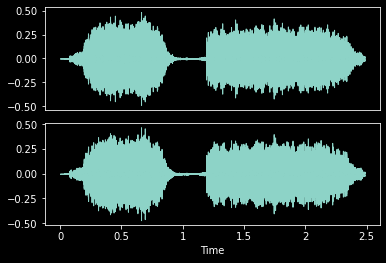

In [ ]:
#hide
from fastxtend.test_utils import *
import torchaudio
import matplotlib.pyplot as plt
audio = TensorAudio.create(TEST_AUDIO)
audio.show(hear=False)

## TensorAudio Transforms

In [ ]:
#exporti
def _get_audio_attr(x:TensorAudio|TensorSpec|TensorMelSpec|tuple[TensorAudio|TensorSpec|TensorMelSpec,...], attr:str) -> Any:
    if isinstance(x, tuple): return getattr(x[0], attr)
    else:                    return getattr(x, attr)

## Waveform Item Transforms

In [ ]:
#export
class Flip(RandTransform):
    order, split_idx = 5, 0
    def __init__(self, p:float=0.5): 
        super().__init__(p=p)

    def encodes(self, x:TensorAudio) -> Tensor:
        return x.fliplr()

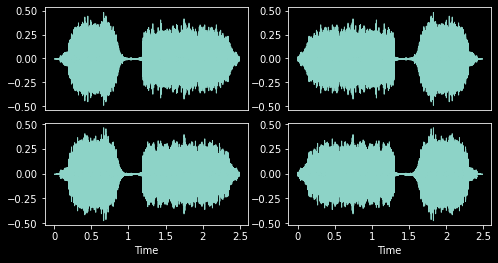

In [ ]:
with less_random():
    _,axs = plt.subplots(1,2,figsize=(8,4))
    f = Flip()
    for ax in axs: f(audio, split_idx=0).show(ctx=ax, hear=False)

### Roll -

In [ ]:
#export
class Roll(RandTransform):
    order, split_idx = 6, 0
    def __init__(self, 
        p:float=0.5,
        max_roll:float=0.5,
    ):
        store_attr('max_roll')
        super().__init__(p=p)
    
    def before_call(self,
        b:TensorAudio|tuple[TensorAudio,...],
        split_idx:int # Index of the train/valid dataset
    ):
        super().before_call(b, split_idx)
        if split_idx==0: self.shift = int(random.uniform(-1,1) * self.max_roll * _get_audio_attr(b, 'samples'))

    def encodes(self, x:TensorAudio) -> Tensor:
        return x.roll(shifts=self.shift, dims=-1)

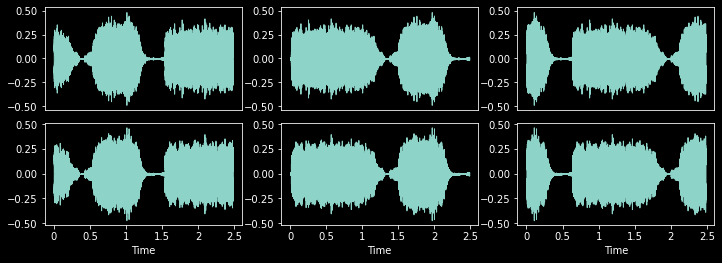

In [ ]:
with less_random():
    _,axs = plt.subplots(1,3,figsize=(12,4))
    f = Roll(p=1,max_roll=0.5)
    for ax in axs: f(audio, split_idx=0).show(ctx=ax, hear=False)

### RandomCropPad -

In [ ]:
#export
class AudioPadMode(Enum):
    "All methods of padding audio as attributes to get tab-completion and typo-proofing",
    Constant = 1
    ConstantPre = 2
    ConstantPost = 3
    Repeat = 4
    Reflect = 5

In [ ]:
#exporti
@patch
def crop_pad(x:TensorAudio, 
    end_len:int,
    crop_start:int|None=None,
    pad_len:int=0, 
    padmode:AudioPadMode=AudioPadMode.Repeat,
    constant:float=0
):
    if crop_start is not None:
        x = x[...,crop_start:crop_start+end_len]
    elif pad_len:
        if padmode==AudioPadMode.ConstantPre:
            x = _VF.constant_pad_nd(x, (pad_len, 0), constant)
        elif padmode==AudioPadMode.ConstantPost:
            x = _VF.constant_pad_nd(x, (0, pad_len), constant)
        elif padmode==AudioPadMode.Repeat:
            if pad_len >= end_len:
                x = x.repeat(1, 1+max(pad_len//end_len, 1))
            else:
                x = torch.cat([x, x[...,0:pad_len]], dim=-1)
        else:
            if pad_len % 2 == 0: pad = pad_len//2
            else:                pad = pad_len//2 + 1
            if padmode==AudioPadMode.Constant:
                x = _VF.constant_pad_nd(x, (pad, pad), constant)
            elif padmode==AudioPadMode.Reflect:
                x = torch._C._nn.reflection_pad1d(x, (pad, pad))

    if x.samples > end_len:
        x = x[...,0:end_len]
    return x

In [ ]:
#export
class RandomCropPad(RandTransform):
    split_idx, order = None, 25
    def __init__(self, 
        duration:Number|None=None, # Crop length in seconds
        samples:int|None=None, # Crop length in samples
        padmode:AudioPadMode=AudioPadMode.Constant,
        constant:Number=0
    ):
        if duration is None and samples is None:
            raise ValueError('One of `duration` or `samples` must be set')
        if constant >= 1 or constant <= -1:
            raise ValueError('`constant` must be between [-1,1]')
        store_attr()
        super().__init__()
    
    def before_call(self,
        b:TensorAudio|tuple[TensorAudio,...],
        split_idx:int # Index of the train/valid dataset
    ):
        self.samples = self.samples if self.samples is not None else int(self.duration*_get_audio_attr(b, 'sr'))
        self.orig_samples = _get_audio_attr(b, 'samples')
        if split_idx:
            self.crop_start = (self.orig_samples-self.samples)//2 if self.samples < self.orig_samples else None
        else:
            self.crop_start = torch.randint(0,self.orig_samples-self.samples, (1,)) if self.samples < self.orig_samples else None
        
        self.pad_len = (self.samples-self.orig_samples) if self.samples > self.orig_samples else 0

    def encodes(self, x:TensorAudio) -> Tensor:
        return x.crop_pad(self.samples, self.crop_start, self.pad_len, self.padmode, self.constant)

`RandomCropPad` will pad using one of the following five modes if the input length is less than `duration` or `samples`.

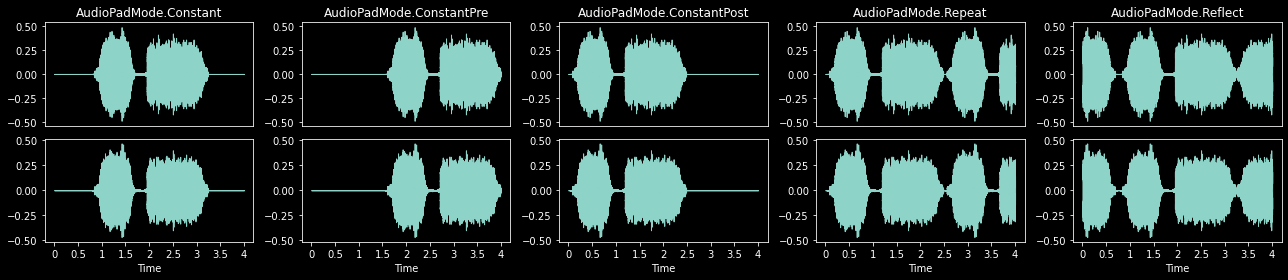

In [ ]:
with less_random():
    _,axs = plt.subplots(1,5,figsize=(18,4))
    for ax,padmode in zip(axs.flatten(), [AudioPadMode.Constant, AudioPadMode.ConstantPre,
                                          AudioPadMode.ConstantPost, AudioPadMode.Repeat, 
                                          AudioPadMode.Reflect]
    ):
        rcp = RandomCropPad(4, padmode=padmode)
        rcp(audio, split_idx=1).show(ctx=ax, title=padmode, hear=False)
        plt.tight_layout()

During training, `RandomCropPad` will randomly crop if the input length is greater than `duration` or `samples`.

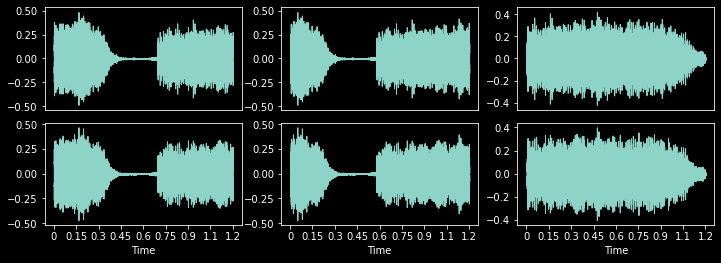

In [ ]:
with less_random():
    _,axs = plt.subplots(1,3,figsize=(12,4))
    rcp = RandomCropPad(1.2)
    for ax in axs: rcp(audio, split_idx=0).show(ctx=ax, hear=False)

During validation or prediction, `RandomCropPad` will center crop if the input length is greater than `duration` or `samples`.

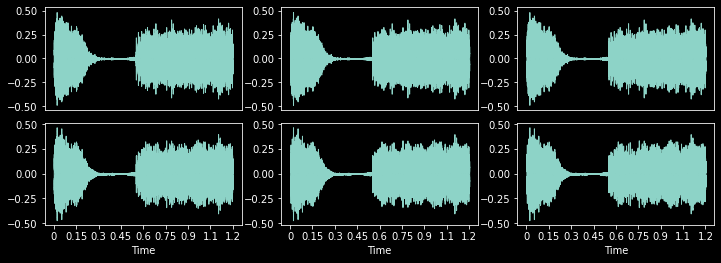

In [ ]:
with less_random():
    _,axs = plt.subplots(1,3,figsize=(12,4))
    rcp = RandomCropPad(1.2)
    for ax in axs: rcp(audio, split_idx=1).show(ctx=ax, hear=False)

### Volume -

In [ ]:
#export
class VolumeMode(Enum):
    "All AmplitudeToDB mode's as attributes to get tab-completion and typo-proofing",
    DB = 1
    Power = 2
    Amplitude = 3

In [ ]:
# export
class Volume(RandTransform):
    order, split_idx = 30, 0
    def __init__(self, 
        p:float=0.5,
        gain:Number|None=None, # If none, randomly select from `gain_range`
        gain_range:tuple[Number,Number] = (-18, 6),
        vol_mode:VolumeMode=VolumeMode.DB # One of "db", "amplitude", or "power"
    ): 
        super().__init__(p=p)
        if vol_mode != VolumeMode.DB:
            gain_range = (max(gain_range[0],0), gain_range[1])
        self.random_gain = gain is None
        store_attr(but='p')

    def before_call(self,
        b:TensorAudio|tuple[TensorAudio,...],
        split_idx:int # Index of the train/valid dataset
    ):
        super().before_call(b, split_idx)
        if split_idx==0 and self.random_gain: self.gain = random.uniform(*self.gain_range)

    def encodes(self, x:TensorAudio) -> Tensor:
        if self.vol_mode == VolumeMode.DB:
            x = TAF.gain(x, self.gain)
        elif self.vol_mode == VolumeMode.Amplitude:
            x = x * self.gain
        elif self.vol_mode == VolumeMode.Power:
            x = TAF.gain(x, 10 * math.log10(self.gain))

        return torch.clamp(x, -1, 1)

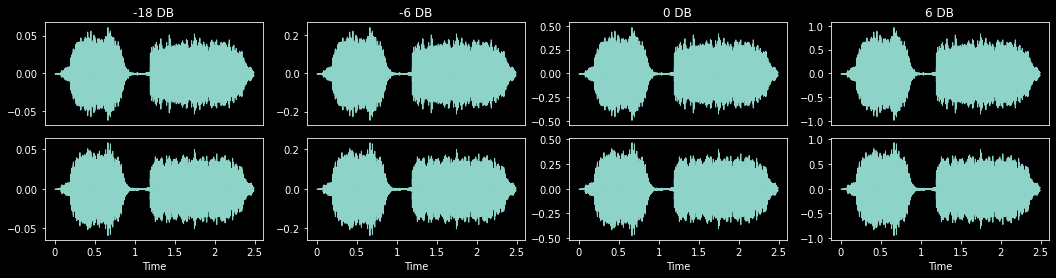

In [ ]:
_,axs = plt.subplots(1,4,figsize=(18,4))
for ax,gain in zip(axs.flatten(), [-18, -6, 0, 6]):
    vol = Volume(p=1., gain=gain)
    vol(audio, split_idx=0).show(ctx=ax, title=f'{gain} DB', hear=False)

## Waveform Batch Transforms

### Volume -

In [ ]:
#export
class VolumeBatch(BatchRandTransform):
    order, split_idx = 10, 0
    def __init__(self, 
        p:float=0.5,
        gain:Number|None=None, # If none, randomly select from `gain_range`
        gain_range:tuple[Number,Number] = (-18, 6),
        vol_mode:VolumeMode=VolumeMode.DB # One of "db", "amplitude", or "power"
    ): 
        super().__init__(p=p)
        if vol_mode != VolumeMode.DB:
            gain_range = (max(gain_range[0],0), gain_range[1])
        self.random_gain = gain is None
        store_attr(but='p')

    def before_call(self,
        b:TensorAudio|tuple[TensorAudio,...],
        split_idx:int # Index of the train/valid dataset
    ):
        super().before_call(b, split_idx)
        if split_idx==0 and self.random_gain: self.gain = random.uniform(*self.gain_range)

    def encodes(self, x:TensorAudio) -> Tensor:
        if self.vol_mode == VolumeMode.DB:
            x = TAF.gain(x, self.gain)
        elif self.vol_mode == VolumeMode.Amplitude:
            x = x * self.gain
        elif self.vol_mode == VolumeMode.Power:
            x = TAF.gain(x, 10 * math.log10(self.gain))

        return torch.clamp(x, -1, 1)

### PitchShift -

In [ ]:
#export
class PitchShift(BatchRandTransform):
    "Shift TensorAudio's pitch using `torch_pitch_shift`"
    order, split_idx = 20, 0
    def __init__(self, 
        p:float=0.2,
        semitones:tuple[float,float]=(-4.0,4.0), # Random pitch shift range in semitones to select computation efficient shifts
        bins_per_octave:int=12, # Number of steps per octave
    ):
        super().__init__(p=p)
        store_attr(but='p')
        self.sr = 0

    def before_call(self,
        b:TensorAudio|tuple[TensorAudio,...],
        split_idx:int # Index of the train/valid dataset
    ):
        super().before_call(b, split_idx)
        if not self.sr: 
            self.sr = _get_audio_attr(b, 'sr')
            self._fast_shifts = get_fast_shifts(self.sr, self._validate_fast_shifts)
        if split_idx==0: self.shift = random.choice(self._fast_shifts)

    def encodes(self, x:TensorAudio) -> Tensor:
        return pitch_shift(x.clone(), self.shift, self.sr, self.bins_per_octave)

    def _validate_fast_shifts(self, x):
        return x >= semitones_to_ratio(self.semitones[0]) and x <= semitones_to_ratio(self.semitones[1]) and x != 1

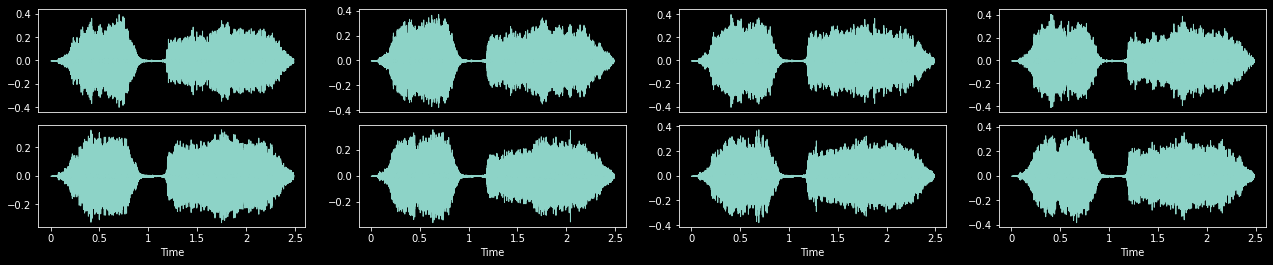

In [ ]:
with less_random():
    _,axs = plt.subplots(1,4,figsize=(22,4))
    ps = PitchShift(p=1.)
    for ax in axs.flatten():
        audio = TensorAudio.create(TEST_AUDIO)
        ps(audio.unsqueeze(0), split_idx=0).squeeze(0).show(ctx=ax, hear=False)

### PitchShiftTA -

In [ ]:
#export
class PitchShiftTA(BatchRandTransform):
    "Shift the TensorAudio's pitch using TorchAudio. Can be slower than `PitchShift`"
    order, split_idx = 20, 0
    def __init__(self, 
        p:float=0.2,
        n_steps:int|None=None, # The (fractional) steps to shift waveform
        n_step_range:tuple[int,int] = (2,6), # Random `n_steps` range if `n_steps` is None
        bins_per_octave:int=12, # Number of steps per octave
        n_fft:int=512, # Size of FFT, creates n_fft // 2 + 1 bins
        win_length:int|None=None, # Window size. Defaults to `n_fft`
        hop_length:int|None=None, # Length of hop between STFT windows. Defaults to `win_length` // 4
        window_fn:Callable[..., Tensor]=torch.hann_window, # Window tensor applied/multiplied to each frame/window
        wkwargs:dict|None=None, # Args for `window_fn`
    ):
        super().__init__(p=p)
        store_attr(but='p,window_fn,wkwargs')
        self.sr=0
        self.win_length = win_length if win_length is not None else n_fft
        self.hop_length = hop_length if hop_length is not None else self.win_length // 4
        self.window = window_fn(self.win_length) if wkwargs is None else window_fn(self.win_length, **wkwargs)

    def before_call(self,
        b:TensorAudio|tuple[TensorAudio,...],
        split_idx:int # Index of the train/valid dataset
    ):
        super().before_call(b, split_idx)
        if not self.sr: self.sr = _get_audio_attr(b, 'sr')
        if split_idx==0:
            self.steps = random.uniform(*self.n_step_range) if self.n_steps is None else self.n_steps

    def encodes(self, x:TensorAudio) -> Tensor:
        return TAF.pitch_shift(x, self.sr, self.steps, self.bins_per_octave, self.n_fft, 
                               self.win_length, self.hop_length, self.window)

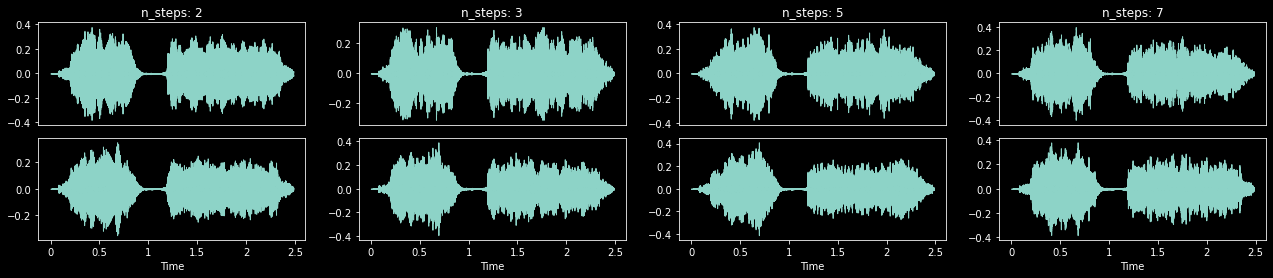

In [ ]:
_,axs = plt.subplots(1,4,figsize=(22,4))
for ax,steps in zip(axs.flatten(), [2, 3, 5, 7]):
    ps = PitchShiftTA(p=1., n_steps=steps)
    audio = TensorAudio.create(TEST_AUDIO)
    ps(audio.unsqueeze(0), split_idx=0).squeeze(0).show(ctx=ax, title=f'n_steps: {steps}', hear=False)

### TimeStretch -

In [ ]:
#export
class TimeStretch(BatchRandTransform):
    order, split_idx = 25, 0
    def __init__(self, 
        p:float=0.2,
        stretch_rates:tuple[float,float]=(0.5,2.0), # Random time stretch range in semitones to select computation efficient stretches. Defaults to 50%-200% speed
        padmode:AudioPadMode=AudioPadMode.Repeat,
        constant:Number=0,
    ):
        super().__init__(p=p)
        store_attr(but='p')
        self.sr = 0

    def before_call(self,
        b:TensorAudio|tuple[TensorAudio,...],
        split_idx:int # Index of the train/valid dataset
    ):
        super().before_call(b, split_idx)
        if not self.sr: 
            self.sr = _get_audio_attr(b, 'sr')
            self._fast_stretchs = get_fast_stretches(self.sr, self._validate_fast_stretches)
            self.shape = _get_audio_attr(b, 'shape')
        if split_idx==0: self.stretch = float(1/random.choice(self._fast_stretchs))

    def encodes(self, x:TensorAudio) -> Tensor:
        x = retain_type(time_stretch(x.clone(), self.stretch, self.sr), typ=TensorAudio)
        crop_start = torch.randint(0, x.shape[-1]-self.shape[-1], (1,)) if self.shape[-1] < x.shape[-1]  else None
        pad_len = (self.shape[-1]-x.shape[-1]) if self.shape[-1] > x.shape[-1] else 0
        return x.crop_pad(self.shape[-1], crop_start, pad_len, self.padmode, self.constant)


    def _validate_fast_stretches(self, x):
        return x >= self.stretch_rates[0] and x <= self.stretch_rates[1] and x != 1

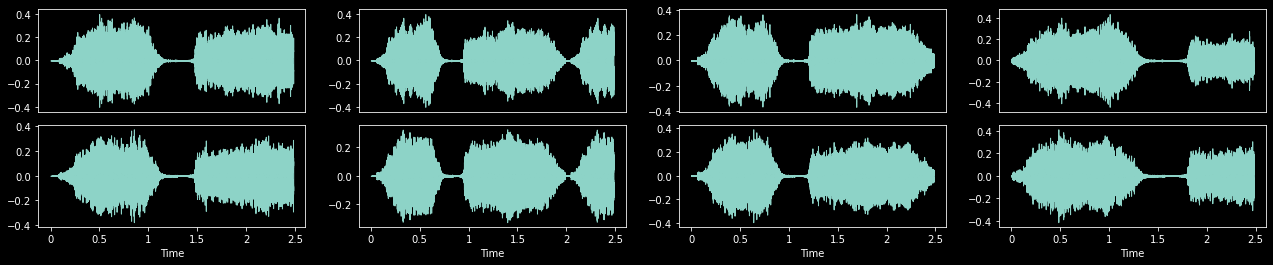

In [ ]:
with less_random():
    _,axs = plt.subplots(1,4,figsize=(22,4))
    ts = TimeStretch(p=1.)
    for ax in axs.flatten():
        audio = TensorAudio.create(TEST_AUDIO)
        ts(audio.unsqueeze(0), split_idx=0).squeeze(0).show(ctx=ax, hear=False)

## TensorMelspec Transforms
All are batch transforms

<AxesSubplot:>

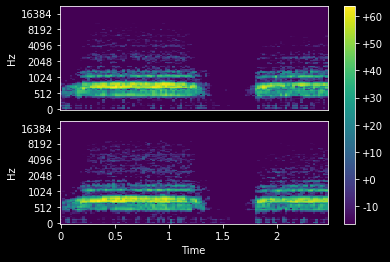

In [ ]:
from fastxtend.audio.data import MelSpectrogram
# audio = TensorAudio.create(TEST_AUDIO)
mel = MelSpectrogram(audio.sr, hop_length=1024, n_fft=1024, n_mels=112)(audio)
mel.show(to_db=True)

### TimeMasking -

In [ ]:
#export
class TimeMasking(BatchRandTransform):
    split_idx, order = 0, 81
    def __init__(self,
        p:float=0.25, # Per-item probability
        max_mask:float=0.2, # Maximum possible length of the mask  [0, max_mask)
        iid_masks:bool=True, # Apply different masks to each example/channel in the batch
        mask_value:int|None=0 # If None, random value between batch min and max
    ):
        store_attr(but='p')
        super().__init__(p=p)

    def before_call(self,
        b:TensorSpec|tuple[TensorSpec,...],
        split_idx:int # Index of the train/valid dataset
    ):
        super().before_call(b, split_idx)
        self.mask_param = int(self.max_mask * _get_audio_attr(b, 'shape')[-1])
        if split_idx==0 and self.mask_value is None:
            self.mv = random.randint(int(_get_audio_attr(b, 'min')), int(_get_audio_attr(b, 'max')))  
        else: 
            self.mv = self.mask_value 

    def encodes(self, x:TensorSpec|TensorMelSpec) -> Tensor:
        if self.iid_masks and x.dim() == 4:
            return TAF.mask_along_axis_iid(x, self.mask_param, self.mv, 3)
        else:
            return TAF.mask_along_axis(x, self.mask_param, self.mv, 2)

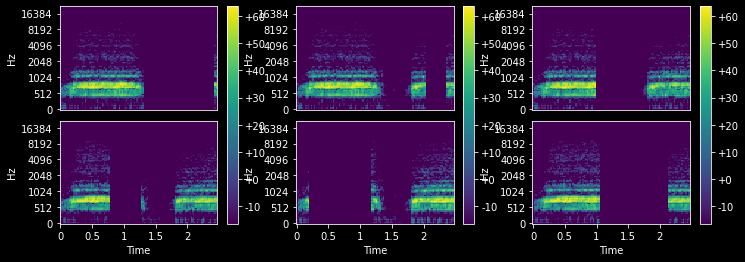

In [ ]:
with less_random():
    _,axs = plt.subplots(1,3,figsize=(12,4))
    tm = TimeMasking(p=1., max_mask=0.5)
    for ax in axs: 
        mel = MelSpectrogram(audio.sr, hop_length=1024, n_fft=1024, n_mels=112)(audio)
        tm(mel.unsqueeze(0), split_idx=0).squeeze(0).show(ctx=ax, to_db=True)

### FrequencyMasking -

In [ ]:
#export
class FrequencyMasking(BatchRandTransform):
    split_idx, order = 0, 82
    def __init__(self,
        p:float=0.25, # Per-item probability
        max_mask:float=0.2, # Maximum possible length of the mask [0, max_mask)
        iid_masks:bool=True, # Apply different masks to each example/channel in the batch
        mask_value:int|None=0 # If None, random value between batch min and max 
    ):
        store_attr(but='p')
        super().__init__(p=p)

    def before_call(self,
        b:TensorSpec|tuple[TensorSpec,...],
        split_idx:int # Index of the train/valid dataset
    ):
        super().before_call(b, split_idx)
        self.mask_param = int(self.max_mask * _get_audio_attr(b, 'shape')[-2])
        if split_idx==0 and self.mask_value is None:
            self.mv = random.randint(int(_get_audio_attr(b, 'min')), int(_get_audio_attr(b, 'max')))  
        else: 
            self.mv = self.mask_value 

    def encodes(self, x:TensorSpec|TensorMelSpec) -> Tensor:
        if self.iid_masks and x.dim() == 4:
            return TAF.mask_along_axis_iid(x, self.mask_param, self.mv, 2)
        else:
            return TAF.mask_along_axis(x, self.mask_param, self.mv, 1)

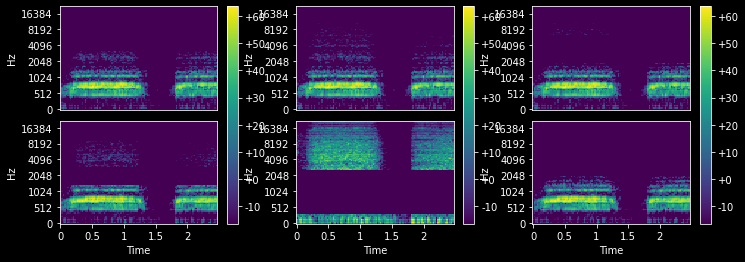

In [ ]:
with less_random():
    _,axs = plt.subplots(1,3,figsize=(12,4))
    fm = FrequencyMasking(p=1., max_mask=0.5)
    for ax in axs:
        mel = MelSpectrogram(audio.sr, hop_length=1024, n_fft=1024, n_mels=112)(audio)
        fm(mel.unsqueeze(0), split_idx=0).squeeze(0).show(ctx=ax, to_db=True)

### SpecAugment -

### AmplitudeToDB -

In [ ]:
#export
class AmplitudeToDBMode(Enum):
    "All AmplitudeToDB mode's as attributes to get tab-completion and typo-proofing",
    Power = 'power'
    Magnitude = 'magnitude'

In [ ]:
#export
class AmplitudeToDB(DisplayedTransform):
    order = 98
    def __init__(self,
        top_db:float|None=None,
        mode:AmplitudeToDBMode=AmplitudeToDBMode.Power
    ):
        self.amdb = tatfms.AmplitudeToDB(mode.value, top_db)

    def encodes(self, x:TensorSpec|TensorMelSpec) -> Tensor:
        return self.amdb(x)

    def to(self, *args, **kwargs):
        device, dtype, non_blocking, convert_to_format = torch._C._nn._parse_to(*args, **kwargs)
        self.amdb.to(device)

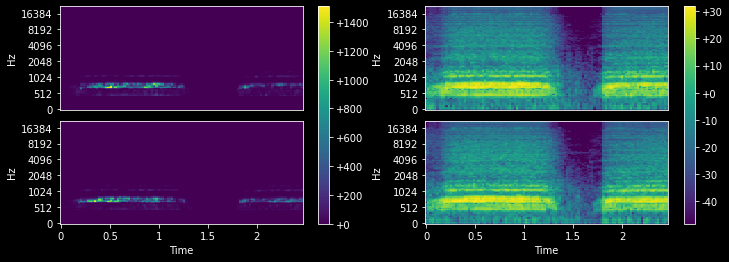

In [ ]:
with less_random():
    _,axs = plt.subplots(1,2,figsize=(12,4))
    adb = AmplitudeToDB(top_db=80)
    for i, ax in enumerate(axs):
        if i==1:
            mel = MelSpectrogram(audio.sr, hop_length=1024, n_fft=1024, n_mels=112)(audio)
            adb(mel.unsqueeze(0), split_idx=0).squeeze(0).show(ctx=ax)
        else:
           mel = MelSpectrogram(audio.sr, hop_length=1024, n_fft=1024, n_mels=112)(audio)
           mel.show(ctx=ax)

### Normalize -

In [ ]:
#export
@patch
def encodes(self:Normalize, x:TensorSpec|TensorMelSpec): 
    return (x-self.mean) / self.std

@patch
def decodes(self:Normalize, x:TensorSpec|TensorMelSpec):
    f = to_cpu if x.device.type=='cpu' else noop
    return (x*f(self.std) + f(self.mean))